In [2]:
import sys
import pickle
import numpy as np
import tensorflow as tf
import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

##### Set the path to directory containing code of this case

In [3]:
new_path = r'/home/users/suihong/5-cond_well_globalfeatures_probmap/'
sys.path.append(new_path)

#### Set the path to data directory; this directory includes two datasets: "trainingdata" and "testdata"

In [4]:
data_dir_test = '/scratch/users/suihong/DataSets(MultiChannels_V4_Consistency_HighestFrequcyDownSampling)/'

#### Set path to trained network

In [5]:
# 19200 means totally 19200 thousand training images (facies models) used for the training
network_dir = '/scratch/users/suihong/ProGAN_MultiChannel_Reusults_ConditionedtoMultiConditions_TF/1032-pgan-2gpu-CondMud_0.2-CondWell_0.25-Enlarg-CondProb_0.2-new-FS/'
network_name = 'network-snapshot-013440.pkl'

### 1. Fetch dataset

In [6]:
# Initialize TensorFlow session.
tf.InteractiveSession()

import dataset
# tfrecord_dir='TestData' to fetch test dataset, if tfrecord_dir='TrainingData' to fetch training dataset
# labeltypes: 0 for 'channelorientation', 1 for 'mudproportion', 2 for 'channelwidth', 3 for 'channelsinuosity'
# well_enlarge: if True, well points occupy 4x4 area, otherwise occupy 1x1 area
test_set = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestData', labeltypes = [1,2,3], well_enlarge = True, shuffle_mb = 0, prefetch_mb = 0)

# labels are from -1 to 1
image_test, label_test = test_set.get_minibatch_imageandlabel_np(3000)  
probimg_test, wellfacies_test = test_set.get_minibatch_probandwell_np(3000*8)

# To get original well facies data (before enlargement)
test_set_1 = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestData', labeltypes = [1,2,3], well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)
_, wellfacies_test_org = test_set_1.get_minibatch_probandwell_np(3000*8)

Streaming data using dataset.TFRecordDataset...
Dataset shape = [1, 64, 64]
Dynamic range = [0, 255]
Label size    = 3
Streaming data using dataset.TFRecordDataset...
Dataset shape = [1, 64, 64]
Dynamic range = [0, 255]
Label size    = 3


In [7]:
print(image_test.shape)
print(label_test.shape)
print(probimg_test.shape)
print(wellfacies_test.shape)

(3000, 1, 64, 64)
(3000, 3)
(24000, 1, 64, 64)
(24000, 1, 64, 64)


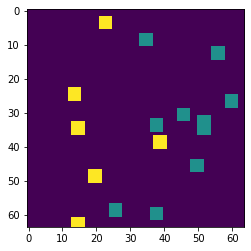

In [8]:
plt.imshow(wellfacies_test[55,0])

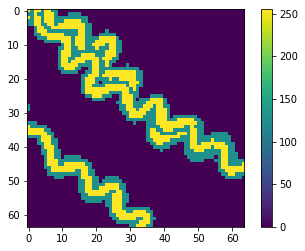

In [9]:
plt.imshow(image_test[60,0])
plt.colorbar()

#### Global features are kept and inputted into Networks with the scale of -1 to 1. To recover the global features into its original scales, use the below transformation functions.


In [10]:
#orit_test = (label_test[:,0]/2+0.5)*168-84
back_ratio_test = (label_test[:,0]/2+0.5)*0.8037109375+0.167724609375
width_test = (label_test[:,1]/2+0.5)*0.8+2.7
amwv_ratio_test = (label_test[:,2]/2+0.5)*0.4866197183098592+0.06338028169014084

### 2. Import pre-trained Network

In [11]:
# Initialize TensorFlow session.
tf.InteractiveSession()

# Import networks.
with open(network_dir+network_name, 'rb') as file:
    G, D, Gs = pickle.load(file)

/share/software/user/open/py-tensorflow/1.12.0_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '



### 3. Evaluation of the imported pretrained Generator


### 3.1 Fetch 300 inputs from Test dataset

In [12]:
# Sample 300 global features, probability maps, and well facies data
faciesmodels_real = image_test[:3000]
labels_inspect = label_test[:3000]
proborder = np.arange(3000) * 8 + np.random.RandomState(32).randint(0, 8, size=3000)
probimg_inspect = np.float32(probimg_test[proborder])

wellfacies_inspect_init = wellfacies_test[proborder]
wellfacies_points_inspect = np.where(wellfacies_inspect_init>0, 1, 0)
wellfacies_facies_inspect = np.where(wellfacies_inspect_init<1.5, 0, 1)
wellfacies_inspect = np.concatenate([wellfacies_points_inspect, wellfacies_facies_inspect], 1)

In [13]:
print(labels_inspect.shape)
print(wellfacies_inspect.shape)
print(probimg_inspect.shape)

(3000, 3)
(3000, 2, 64, 64)
(3000, 1, 64, 64)


##### Create masks to only output visualize well facies against white background

In [14]:
### Enlarge areas of well points for displaying ###
wellfacies_onechannel = wellfacies_inspect[:,0:1]+wellfacies_inspect[:,1:2]
wellfacies_onechannel_mask = np.ma.masked_where(wellfacies_onechannel == 0, wellfacies_onechannel)
cmap_well = plt.cm.viridis  # Can be any colormap that you want after the cm   '.
cmap_well.set_bad(color='white')

### 3.2 General visual assessment

####  Visual assessment on realism, diversity, conditioning to global features, conditioning to well facies data

* (1) Input corresponding global features with well data into trained Generator

   Second column corresponds to ground truth for well facies data and global features.

In [15]:
print(Gs.input_shapes)

[[None, 128], [None, 1], [None, 2, 64, 64], [None, 1, 64, 64]]


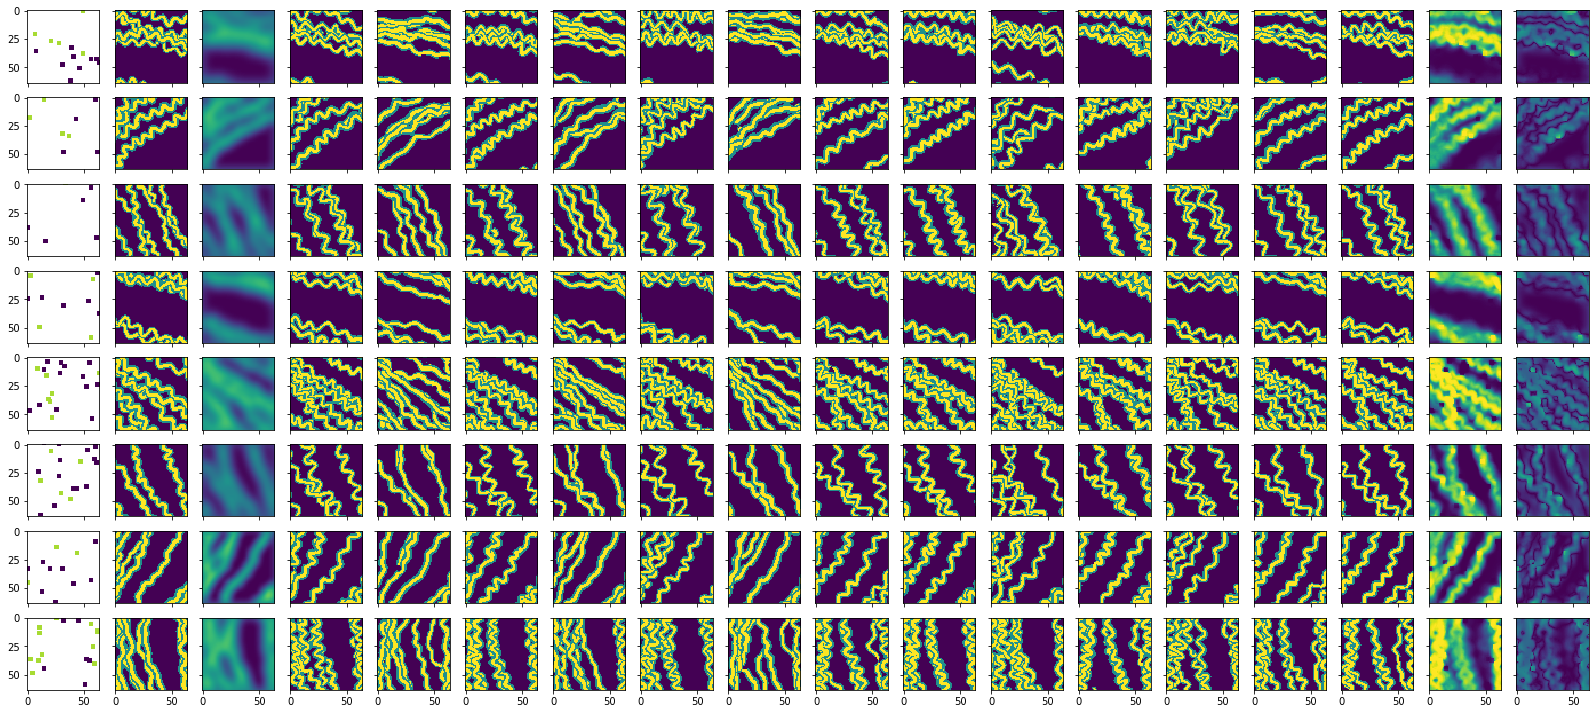

In [16]:
fig, ax = plt.subplots(8, 18, sharex='col', sharey='row')
fig.set_size_inches(28, 12.5, forward=True)

generate_facies_probs = np.zeros((8,1,64,64), dtype=np.float32)
images_plt_average = np.zeros((8,1,64,64))

for i in range (8):

    ax[i, 0].imshow(wellfacies_onechannel_mask[i,0], cmap=cmap_well, vmax = 2.15)
    ax[i, 1].imshow(faciesmodels_real[i,0,:,:]) 
    ax[i, 2].imshow(probimg_inspect[i,0,:,:],vmin = 0.0, vmax = 1.0)         
    
    latents_plt = np.random.RandomState(816).randn(1000, Gs.input_shapes[0][1])
    labels_plt = np.repeat(np.expand_dims(labels_inspect[i,0:1], axis=0), 1000, axis=0)  ## 
    wellfacies_plt = np.repeat(np.expand_dims(wellfacies_inspect[i], axis=0), 1000, axis=0)
    probimg_plt = np.repeat(np.expand_dims(probimg_inspect[i], axis=0), 1000, axis=0)
    
    images_plt = Gs.run(latents_plt, labels_plt, wellfacies_plt, probimg_plt)
    images_plt = np.where(images_plt< -0.3, -1, images_plt)
    images_plt = np.where(images_plt> 0.3, 1, images_plt)
    images_plt = np.where((images_plt> -0.4) & (images_plt< 0.4), 0, images_plt)    
    for j in range(3,16):
        ax[i, j].imshow(images_plt[j-3,0,:,:])
    
    images_plt_a = np.where(images_plt> -0.3, 1, 0)  
    images_plt_average[i] = np.average(images_plt_a, axis = 0)    
    
    ax[i, 16].imshow(images_plt_average[i,0,:,:],vmin = 0.0, vmax = 1)
    ax[i, 17].imshow(np.absolute(probimg_inspect[i,0] - images_plt_average[i, 0]),vmin = 0.0, vmax = 1)

#plt.savefig(network_dir + "Random facies models with fixed mud prob at each row.png", dpi=200) 

In [17]:
print(back_ratio_test[:8])

[0.5839844  0.55566406 0.5595703  0.62719727 0.35717773 0.63549805
 0.5715332  0.43041992]


* (2) Input random global features as: mud_ratio with in real mud_ratio +/- 0.1; sinuosity and width are totally randomized.

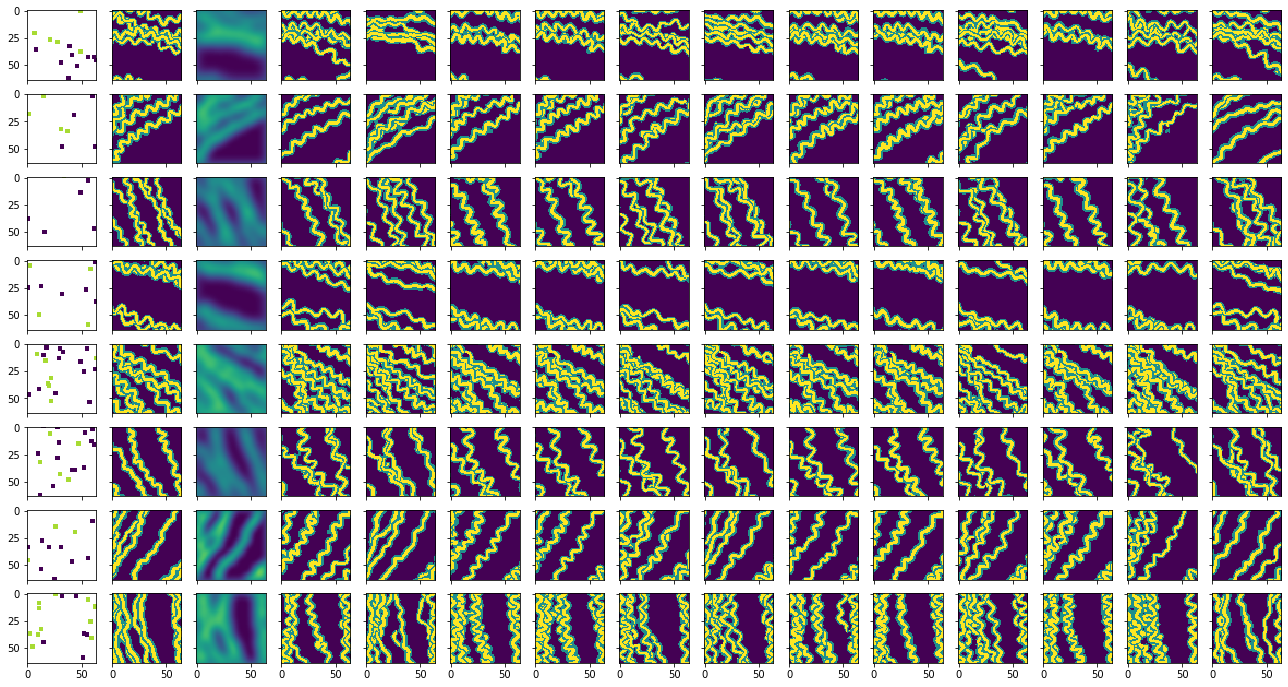

In [18]:
fig, ax = plt.subplots(8, 15, sharex='col', sharey='row')
fig.set_size_inches(22.5, 12, forward=True)

generate_facies_probs = np.zeros((8,1,64,64), dtype=np.float32)
images_plt_average = np.zeros((8,1,64,64))
for i in range (8):

    ax[i, 0].imshow(wellfacies_onechannel_mask[i,0], cmap=cmap_well, vmax = 2.15)
    ax[i, 1].imshow(faciesmodels_real[i,0,:,:]) 
    ax[i, 2].imshow(probimg_inspect[i,0,:,:],vmin = 0.0, vmax = 1.0)         
    
    latents_plt = np.random.RandomState(32).randn(500, Gs.input_shapes[0][1])
    labels_plt = np.repeat(np.expand_dims(labels_inspect[i,0:1], axis=0), 500, axis=0)  
    labels_plt = labels_plt + np.random.uniform(low=-0.2, high=0.2, size=(500,1))    
    wellfacies_plt = np.repeat(np.expand_dims(wellfacies_inspect[i], axis=0), 500, axis=0)
    probimg_plt = np.repeat(np.expand_dims(probimg_inspect[i], axis=0), 500, axis=0)
    
    images_plt = Gs.run(latents_plt, labels_plt, wellfacies_plt, probimg_plt)
    images_plt = np.where(images_plt< -0.3, -1, images_plt)
    images_plt = np.where(images_plt> 0.3, 1, images_plt)
    images_plt = np.where((images_plt> -0.4) & (images_plt< 0.4), 0, images_plt)    
    for j in range(3,15):
        ax[i, j].imshow(images_plt[j-3,0,:,:])

plt.savefig(network_dir + "Random facies models with random (+-10%) mud prob.png", dpi=200) 

### 3.3 Evaluation of Generator's conditioning ability to global features

#### 3.3.1 Visual assessment 

**    Gradully increase input mud facies proportion value from about -10% to 10% of ground truth mud facies proportion  **    

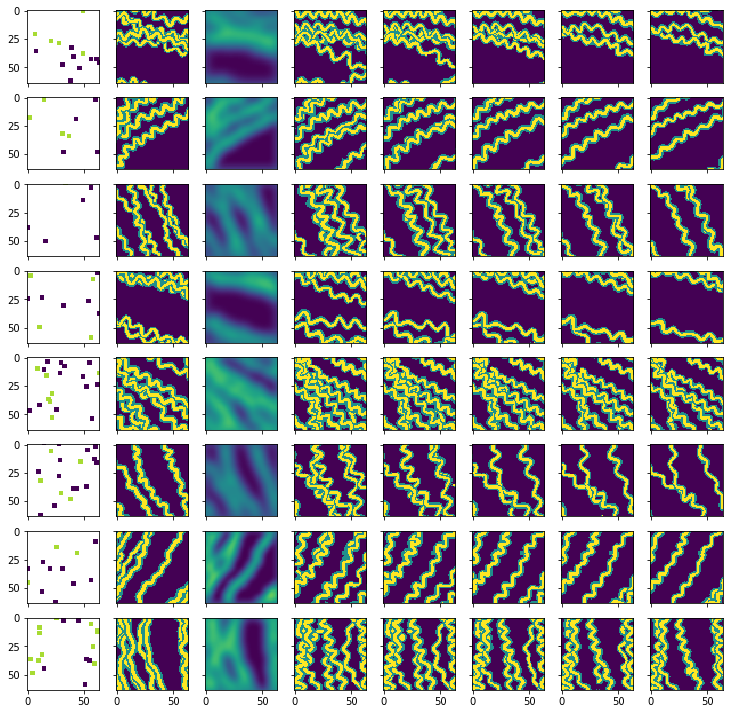

In [19]:
fig, ax = plt.subplots(8, 8, sharex='col', sharey='row')
fig.set_size_inches(12.5, 12.5, forward=True)

generate_facies_probs = np.zeros((8,1,64,64), dtype=np.float32)

images_plt_average = np.zeros((8,1,64,64))
for i in range (8):

    ax[i, 0].imshow(wellfacies_onechannel_mask[i,0], cmap=cmap_well, vmax = 2.15)
    ax[i, 1].imshow(faciesmodels_real[i,0,:,:]) 
    ax[i, 2].imshow(probimg_inspect[i,0,:,:],vmin = 0.0, vmax = 1.0)         
    
    latents_plt = np.repeat(np.random.RandomState(32).randn(1, Gs.input_shapes[0][1]), 5, axis=0)    
    nm = np.expand_dims(np.arange(8,13), axis = 1)    
    labels_plt = ((back_ratio_test[i]*nm*0.1-0.167724609375)/0.8037109375-0.5)*2  # back_ratio_test = (label_test[:,0]/2+0.5)*0.8037109375+0.167724609375   
    wellfacies_plt = np.repeat(np.expand_dims(wellfacies_inspect[i], axis=0), 5, axis=0)
    probimg_plt = np.repeat(np.expand_dims(probimg_inspect[i], axis=0), 5, axis=0)
    
    images_plt = Gs.run(latents_plt, labels_plt, wellfacies_plt, probimg_plt)
    images_plt = np.where(images_plt< -0.3, -1, images_plt)
    images_plt = np.where(images_plt> 0.3, 1, images_plt)
    images_plt = np.where((images_plt> -0.4) & (images_plt< 0.4), 0, images_plt)    
    for j in range(3,8):
        ax[i, j].imshow(images_plt[j-3,0,:,:])
plt.savefig(network_dir +"CondMud_V_Facies Models with gradually increased input mud proportion.png", dpi=200)       

#### 3.3.2 Quantitative assessment by comparing input with actual mud proportion.

In [20]:
back_ratio_no = 500
# Generate latent vectors.
latents_plt = np.random.RandomState(61).randn(back_ratio_no, Gs.input_shapes[0][1]) 
wellfacies_plt = wellfacies_inspect[:back_ratio_no]
probimg_plt = probimg_inspect[:back_ratio_no]
labels_plt = label_test[:back_ratio_no, 0:1]+np.random.uniform(low=-0.4, high=0.4, size=(back_ratio_no,1))    

# Run the generator to produce a set of images.
images_plt = Gs.run(latents_plt, labels_plt, wellfacies_plt, probimg_plt)
images_plt = np.where(images_plt< -0.3, -1, images_plt)
images_plt = np.where(images_plt> 0.3, 1, images_plt)
images_plt = np.where((images_plt> -0.4) & (images_plt< 0.4), 0, images_plt)

# Comparing input and actual calculated mud proportion values in the comparative change space compared to ground truth
actual_mudprop = 1-np.count_nonzero(np.where(images_plt >=-0.5,1,0), (1,2,3))/(64*64)
actual_comparative_mudprop_change = (actual_mudprop)/back_ratio_test[:back_ratio_no]
input_mudprop = (np.squeeze(labels_plt)/2+0.5)*0.8037109375+0.167724609375
input_comparative_mudprop_change = (input_mudprop)/back_ratio_test[:back_ratio_no]


y=0.971708x+(0.035994)
R_square=0.96


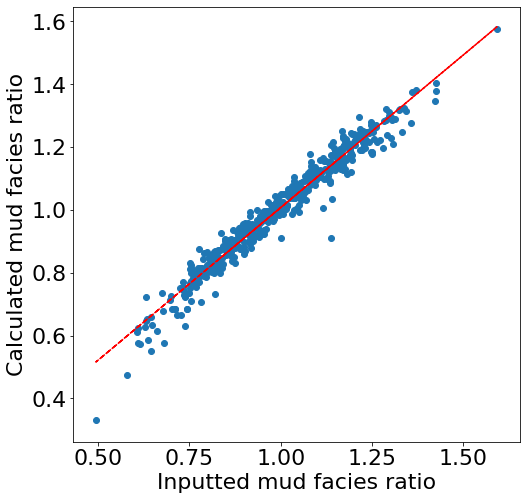

In [21]:
plt.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 8, forward=True)

ax.scatter(input_comparative_mudprop_change, actual_comparative_mudprop_change)
# calc the trendline
z = np.polyfit(input_comparative_mudprop_change, actual_comparative_mudprop_change, 1)
p = np.poly1d(z)
plt.plot(input_comparative_mudprop_change,p(input_comparative_mudprop_change),"r--")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

correlation = np.corrcoef(input_comparative_mudprop_change, actual_comparative_mudprop_change)[0,1]
print("R_square=%.2f"%(correlation**2))

ax.set_xlabel("Inputted mud facies ratio")
ax.set_ylabel("Calculated mud facies ratio")

plt.savefig(network_dir +"CondMud_Q_Mud facies ratio scatter of input vs real in comparative change space.png", dpi=200)   

### 3.4 Evaluation of Generator's conditioning ability to input well data

#### 3.4.1 Visual assessment 

In [22]:
wellfacies_points_org = np.where(wellfacies_test_org>0, 1, 0)
wellfacies_facies_org = np.where(wellfacies_test_org<1.5, 0, 1)
wellfacies_test_org_cc = np.concatenate([wellfacies_points_org, wellfacies_facies_org], 1)

with tf.device('/device:GPU:0'):
    wellfacies_test_org_cc_tf = tf.cast(wellfacies_test_org_cc, tf.float32)
    wellfacies_test_org_cc_el = tf.nn.max_pool(wellfacies_test_org_cc_tf, ksize = [1,1,4,4], strides=[1,1,1,1], padding='SAME', data_format='NCHW') 

with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    wellfacies_test_org_cc_el = sess.run(wellfacies_test_org_cc_el)

wellfacies_test_org_cc_el_onechannel = wellfacies_test_org_cc_el[:,0:1]+wellfacies_test_org_cc_el[:,1:2]
wellfacies_test_org_cc_el_onechannel_mask = np.ma.masked_where(wellfacies_test_org_cc_el_onechannel == 0, wellfacies_test_org_cc_el_onechannel)

cmap_well = plt.cm.viridis  # Can be any colormap that you want after the cm   '.
cmap_well.set_bad(color='white')

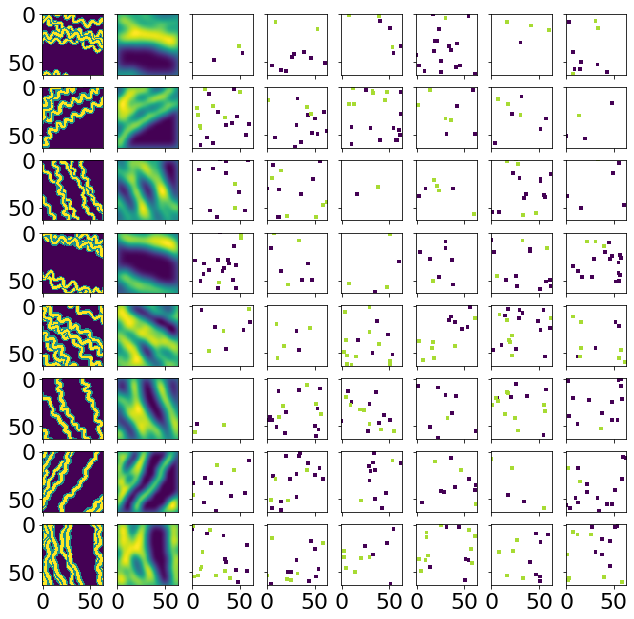

In [23]:
fig, ax = plt.subplots(8, 8, sharex='col', sharey='row')
fig.set_size_inches(10.5, 10.5, forward=True)

images_plt_w1_average = np.zeros((8,1,64,64))
for i in range (8):
    ax[i, 0].imshow(image_test[i,0])
    ax[i, 1].imshow(probimg_inspect[i,0,:,:])

    for j in range(6):
        ax[i, j+2].imshow(wellfacies_test_org_cc_el_onechannel_mask[i*8+j,0,:,:], cmap = cmap_well, vmax = 2.15)
plt.savefig(network_dir + "CondWell_V_Various input well facies sets.png", dpi=200)    

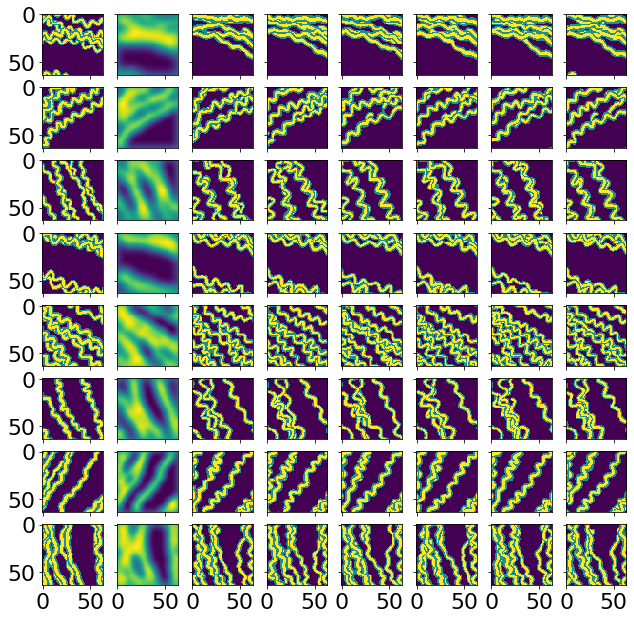

In [24]:
fig, ax = plt.subplots(8, 8, sharex='col', sharey='row')
fig.set_size_inches(10.5, 10.5, forward=True)

images_plt_w1_average = np.zeros((8,1,64,64))
for i in range (8):
    ax[i, 0].imshow(image_test[i,0])
    ax[i, 1].imshow(probimg_inspect[i,0,:,:])
    
    latents_plt_w5 = np.repeat(np.expand_dims(np.random.randn(Gs.input_shapes[0][1]), axis=0), 6, axis=0)# np.random.RandomState(312).randn(1 * 6, Gs.input_shapes[0][1])
    labels_plt_w5 = np.repeat(np.expand_dims(labels_inspect[i,0:1], axis=0), 6, axis=0) #np.random.RandomState(2).randn(1 * 6, Gs.input_shapes[1][1])
    probimg_plt_w5 = np.repeat(np.expand_dims(probimg_inspect[i], axis=0), 6, axis=0)
    wellfacies_plt_w5 = wellfacies_test_org_cc_el[i*8:i*8+6,]
    
    images_plt_w5 = Gs.run(latents_plt_w5, labels_plt_w5, wellfacies_plt_w5, probimg_plt_w5)
    images_plt_w5 = np.where(images_plt_w5< -0.2, -1, images_plt_w5)
    images_plt_w5 = np.where(images_plt_w5> 0.2, 1, images_plt_w5)
    images_plt_w5 = np.where((images_plt_w5>= -0.2) & (images_plt_w5<= 0.2), 0, images_plt_w5)
    
    for j in range(6):
        ax[i, j+2].imshow(images_plt_w5[j,0,:,:])
plt.savefig(network_dir + "CondWell_V_Fake facies models for various input well facies sets.png", dpi=200)     

#### 3.4.1 Quantitative assessment on well facies reproduction accuracy

In [25]:
def generate_images(realization_num): # realization_num<=3000
    
    latents_plt_w2 = np.random.RandomState(312).randn(realization_num, Gs.input_shapes[0][1])
   
    images_plt_w2 = Gs.run(latents_plt_w2, labels_inspect[:realization_num,0:1], wellfacies_inspect[:realization_num], probimg_inspect[:realization_num])
    images_plt_w2 = np.where(images_plt_w2< -0.2, -1, images_plt_w2)
    images_plt_w2 = np.where(images_plt_w2> 0.2, 1, images_plt_w2)
    images_plt_w2 = np.where((images_plt_w2>= -0.2) & (images_plt_w2<= 0.2), 0, images_plt_w2) 

    return images_plt_w2

In [26]:
def well_points_accuracy(well_facies_a, fake_imgs_a):
    gg = well_facies_a[:,0:1] + well_facies_a[:,1:2]
    
    recognized_f1 = np.where((gg==2) & (well_facies_a[:,0:1] * (fake_imgs_a+1) > 0.8), 1, 0)
    f1_prob = np.sum(recognized_f1)/np.sum(np.where(gg==2,1,0))

    recognized_f0 = np.where((gg==1) & (well_facies_a[:,0:1] * (fake_imgs_a+2) ==1), 1, 0)
    f0_prob = np.sum(recognized_f0)/np.sum(np.where(gg==1,1,0))
    
    return f1_prob, f0_prob

In [27]:
images_num = 500
fake_imgs_b = generate_images(images_num)
f_c_prob, f_m_prob = well_points_accuracy(wellfacies_test_org_cc[proborder][:images_num], fake_imgs_b)
print(f_c_prob)
print(f_m_prob)

0.9908443540183113
0.9763828464885022


### 3.5 Evaluation of the Conditioning ability to probability maps

#### 3.4.1 Visual assessment 

In [28]:
def get_random_well_points(images_num):
    well_points = np.zeros([images_num, 1, 64, 64], dtype = int)
    for i in range(images_num):
        well_points_num = np.random.RandomState(3*i).choice(np.arange(8, 16), 1)  # Random choose the expected total number of well points
        xs = np.random.choice(64, well_points_num)
        ys = np.random.choice(64, well_points_num)
        well_points[i, 0, xs, ys] = 1 
    return well_points

In [29]:
def enlarge(well_facies):
    ### Enlarge areas of well points into 4 x 4 as inputs
    with tf.device('/gpu:0'):
        well_facies = tf.cast(well_facies, tf.float32)
        well_facies_enlarge = tf.nn.max_pool(well_facies, ksize = [1,1,4,4], strides=[1,1,1,1], padding='SAME', data_format='NCHW') 
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        well_points_el = sess.run(well_facies_enlarge) 
    return well_points_el

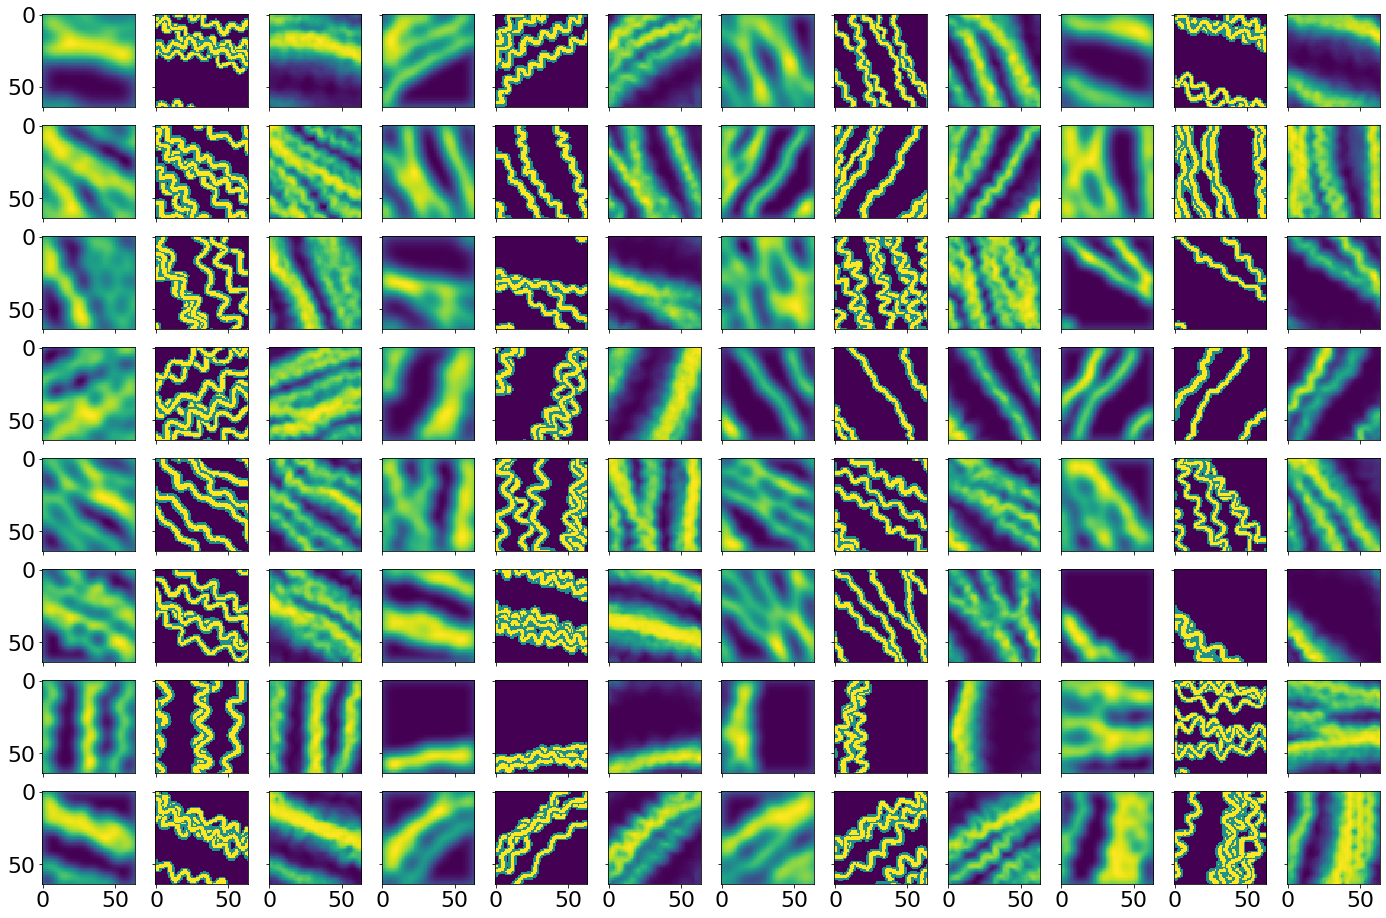

In [30]:
fig, ax = plt.subplots(8, 12, sharex='col', sharey='row')
fig.set_size_inches(24, 16, forward=True)
generate_facies_probs_p1 = np.zeros((32,1,64,64), dtype=np.float32)
for i in range(32): 
    
    probimg_plt_p1 = np.repeat(np.expand_dims(probimg_inspect[i], axis=0), 1000, axis=0)     
    
    latents_plt_p1 = np.random.randn(1000, Gs.input_shapes[0][1])
    labels_plt_p1 = np.repeat(np.expand_dims(labels_inspect[i,0:1], axis=0), 1000, axis=0) +np.random.uniform(low=-0.4, high=0.4, size=(1000,1))               
    
    well_points_p1 = get_random_well_points(1000)
    random_seeds = np.random.uniform(low=0.0, high=1.0, size=well_points_p1.shape)
    well_facies_p1 = np.where(random_seeds<=probimg_plt_p1, 1, 0) * well_points_p1
    
    # Using test facies models to sample faices types at well  points
    #well_facies_p1 = np.where(well_points_p1 * np.repeat(np.expand_dims(image_test[i], axis=0), 1000, axis=0)>0, 1, 0)
    well_facies_p1 = np.concatenate([well_points_p1, well_facies_p1], 1)  
    well_facies_p1 = enlarge(well_facies_p1)
    
    images_plt_p1 = Gs.run(latents_plt_p1, labels_plt_p1, well_facies_p1, probimg_plt_p1)
    images_plt_p1 = np.where(images_plt_p1< -0.3, -1, images_plt_p1)
    images_plt_p1 = np.where(images_plt_p1> 0.3, 1, images_plt_p1)
    images_plt_p1 = np.where((images_plt_p1>= -0.3) & (images_plt_p1<= 0.3), 0, images_plt_p1)
   
    images_plt_a = np.where(images_plt_p1> -0.3, 1, 0)   
    generate_facies_probs_p1[i] = np.average(images_plt_a, axis = 0)   

for i in range (8):
  for j in range(12):
    if (i*12+j)%3==0:
        ax[i, j].imshow(probimg_inspect[int((i*12+j)/3),0,:,:])
    elif (i*12+j)%3==1:
        ax[i, j].imshow(image_test[int((i*12+j-1)/3),0,:,:])
    else:
        ax[i, j].imshow(generate_facies_probs_p1[int((i*12+j-2)/3),0,:,:])
    
plt.savefig(network_dir + "CondProb_V_Fake facies models for various input probmaps.png", dpi=200) 

#### 3.4.2 Quantitative evaluation 

#### Cross plot analysis between input and calculated actual channel complex probability

y=1.321206x+(-0.002771)
R_square=0.88


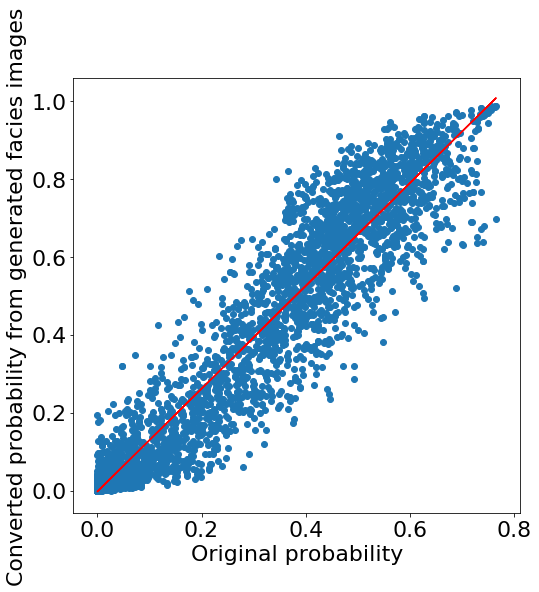

In [31]:
input_probs_1d = probimg_inspect[:32].reshape((-1))
calculated_probs_1d = generate_facies_probs_p1.reshape((-1))
random_sample = np.random.RandomState(3*i).randint(0, 64*64*32, (3000))
input_probs_1d_smp = input_probs_1d[random_sample]
calculated_probs_1d_smp = calculated_probs_1d[random_sample]

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 8, forward=True)

ax.scatter(input_probs_1d_smp, calculated_probs_1d_smp) 
        # calc the trendline
z1 = np.polyfit(input_probs_1d_smp, calculated_probs_1d_smp, 1)
p1 = np.poly1d(z1)
ax.plot(input_probs_1d_smp,p1(input_probs_1d_smp),"r-")
        # the line equation:
print ("y=%.6fx+(%.6f)"%(z1[0],z1[1]))

correlation = np.corrcoef(input_probs_1d_smp, calculated_probs_1d_smp)[0,1]
print("R_square=%.2f"%(correlation**2))

ax.set_xlabel("Original probability")
ax.set_ylabel("Converted probability from generated facies images")
plt.savefig(network_dir + "CondProb_Q_Input prob vs calculated prob cross plot.png", dpi=200) 